## Introduction

I present a reimplementation of the following paper:

> Seppecher, P. (2012). Flexibility of wages and macroeconomic instability in an agent-based computational model with endogenous money. Macroeconomic Dynamics, 16(S2), 284-297.

After replicating the results of the original paper, I present some new questions to examine which test the robustness of the original model.

## Original model

The original paper implements the simulation using Jamel v1 software written by the author. Here I present a top-down reimplementation of the model from the original paper, with the following adjustments:

* Cash values are represented as cents and stored as `int` type, to prevent rounding and representation issues with floating-point numbers.
* Real-valued parameters are likewise represented as an arbitrary-precision `Fraction` type.
* All entities are immutable [why?]
* Entity types have no methods. Instead entity types are purely data stores, and all model mechanics are represented as separate functions. This allows me to write the code in a less fragmented manner, improving readability.

In [147]:
%run seppecher2012.py

from itertools import accumulate

sim = Simulation(
    households = {i : Household(id=i) for i in range(100)},
    firms = {i : Firm(id=i) for i in range(10)}
)
sim = create_bank_accounts(sim)
run = [sim]
for i in range(300):
    if i % 10 == 0:
        print("Step {}".format(i))
    next = run[-1]
    if i == 50:
        next = next._replace(
            bank = next.bank._replace(
                accommodating = False
            )
        )
    run.append(step(next))
print("Done!")

Step 0
Step 10
Step 20
Step 30
Step 40
Step 50
Step 60
Step 70
Step 80
Step 90
Step 100
Step 110
Step 120
Step 130
Step 140
Step 150
Step 160
Step 170
Step 180
Step 190
Step 200
Step 210
Step 220
Step 230
Step 240
Step 250
Step 260
Step 270
Step 280
Step 290
Done!


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

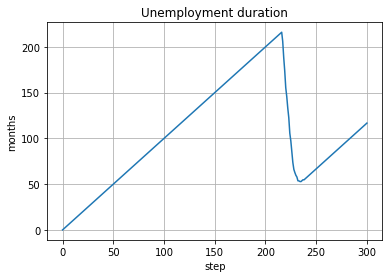

In [148]:
def unemployment_duration(step):
    unemployed = [household for household in list(step.households.values()) if household.employment_status != EmploymentStatus.EMPLOYED]
    return sum([household.unemployment_duration for household in unemployed]) / len(unemployed)

def plot_unemployment_duration(run):
    durations = [unemployment_duration(step) for step in run]
    fig, ax = plt.subplots()
    ax.plot(range(len(durations)), durations)

    ax.set(xlabel='step', ylabel='months',
        title='Unemployment duration')
    ax.grid()

    plt.show()

plot_unemployment_duration(run)

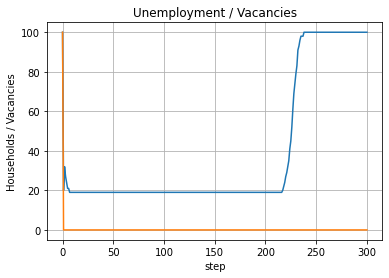

In [149]:

def unemployment_level(step):
    unemployed = [household for household in list(step.households.values()) if household.employment_status != EmploymentStatus.EMPLOYED]
    return len(unemployed)

def vacancies_level(step):
    return sum([firm.hiring_vacancies for firm in step.firms.values()])

def plot_unemployment_vacancies(run):
    unemployment = [unemployment_level(step) for step in run]
    vacancies = [vacancies_level(step) for step in run]
    fig, ax = plt.subplots()
    ax.plot(range(len(unemployment)), unemployment)
    ax.plot(range(len(vacancies)), vacancies)

    ax.set(xlabel='step', ylabel='Households / Vacancies',
        title='Unemployment / Vacancies')
    ax.grid()

    plt.show()

plot_unemployment_vacancies(run)

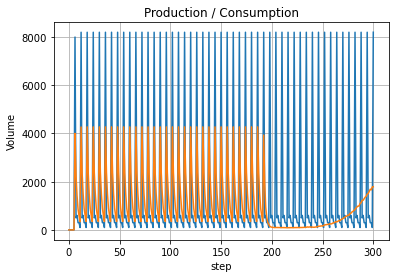

In [150]:
def production_volume(step):
    return sum([firm.production_volume for firm in step.firms.values()])

def consumption_volume(step):
    return sum([household.consumption_volume for household in step.households.values()])

def plot_production_consumption(run):
    production = [production_volume(step) for step in run]
    consumption = [consumption_volume(step) for step in run]
    fig, ax = plt.subplots()
    ax.plot(range(len(production)), production)
    ax.plot(range(len(consumption)), consumption)

    ax.set(xlabel='step', ylabel='Volume',
        title='Production / Consumption')
    ax.grid()

    plt.show()

plot_production_consumption(run)

In [146]:
list(range(2))[-4:]

[0, 1]